#All installation needed for the model



In [1]:
%%capture
!pip install TensorFlow
!pip install Keras
!pip install pillow
!pip install NumPy
!pip install tqdm
!pip install time

# Model loading

In [105]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

from google.colab import auth
auth.authenticate_user()
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse 

!mkdir raw_data
!gcsfuse --implicit-dirs image_caption raw_data

In [11]:
cd raw_data

/home/mohanakrishnan/code/LAnnamaria/quotes_for_posts_783/scripts/mohan/raw_data


In [13]:
ls

dataset_flickr30k.json  flickr30k_images/  glove.6B.300d.txt
Flicker8k_Dataset/      Flickr8k_text/     quotes/


In [14]:
token_path = "Flickr8k_text/Flickr8k.token.txt"
train_images_path = 'Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = 'Flickr8k_text/Flickr_8k.testImages.txt'
images_path = 'Flicker8k_Dataset/'
glove_path = 'glove.6B.300d.txt'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [15]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [16]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

In [17]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [18]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [19]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [20]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [21]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [22]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [23]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [24]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [25]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [26]:
embeddings_index = {} 
f = open(os.path.join(glove_path), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [27]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [28]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

2022-03-07 05:58:40.120225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-07 05:58:40.120774: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 05:58:40.120851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-07 05:58:40.120910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-07 05:58:40.120965: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

96124928/96112376 [==============================] - 8s 0us/step


In [29]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [31]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

In [32]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 300)      498000      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [33]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam', metric = 'accuracy')

In [34]:

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [35]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
2000/2000 [==============================] - 676s 336ms/step - loss: 3.6445
Epoch 2/30
2000/2000 [==============================] - 683s 341ms/step - loss: 2.9825
Epoch 3/30
2000/2000 [==============================] - 676s 338ms/step - loss: 2.7896
Epoch 4/30
2000/2000 [==============================] - 681s 340ms/step - loss: 2.6719
Epoch 5/30
2000/2000 [==============================] - 681s 340ms/step - loss: 2.5871
Epoch 6/30
2000/2000 [==============================] - 678s 339ms/step - loss: 2.5225
Epoch 7/30
2000/2000 [==============================] - 681s 341ms/step - loss: 2.4689
Epoch 8/30
2000/2000 [==============================] - 673s 337ms/step - loss: 2.4279
Epoch 9/30
2000/2000 [==============================] - 679s 339ms/step - loss: 2.3897
Epoch 10/30
2000/2000 [==============================] - 681s 341ms/step - loss: 2.3591
Epoch 11/30
2000/2000 [==============================] - 676s 338ms/step - loss: 2.3329
Epoch 12/30
2000/2000 [==================

In [36]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [37]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

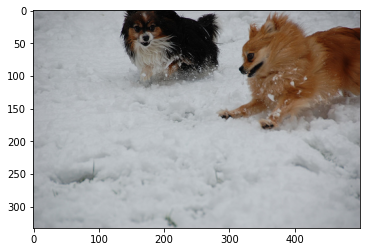

Greedy Search: a dog is running through the snow
Beam Search, K = 3: three dogs play in the snow
Beam Search, K = 5: a brown and white dog is running through the snow
Beam Search, K = 7: a brown and white dog is running through the snow
Beam Search, K = 10: a brown and white dog and a brown and white dog play in the snow


In [104]:
pic = '2398605966_1d0c9e6a20.jpg'
image1 = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image1))
print("Beam Search, K = 3:",beam_search_predictions(image1, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image1, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image1, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image1, beam_index = 10))

In [62]:
ls

dataset_flickr30k.json  flickr30k_images/  glove.6B.300d.txt
Flicker8k_Dataset/      Flickr8k_text/     quotes/


In [109]:
pic1 = 'Flicker8k_Dataset/testing_1.jpg'
inp = image.load_img(pic1,target_size=(299,299))
inp = image.img_to_array(inp)
x = np.expand_dims(inp, axis=0)
x = preprocess_input(x)

In [110]:
def encode_new_image(image):
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [111]:
image1 = encode_new_image(x).reshape((1,2048))

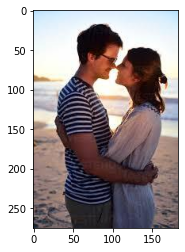

In [112]:
x=plt.imread(pic1)
plt.imshow(x)
plt.show()

Greedy Search: a man in a black shirt is standing in front of a group of people
Beam Search, K = 3: a woman in a white shirt is sitting on a bench near a
Beam Search, K = 5: a group of people sit on the edge of a cement wall
Beam Search, K = 7: a group of people sit on the edge of a cement wall
Beam Search, K = 10: a group of people gather around a bridge


In [115]:
pic2 = 'Flicker8k_Dataset/1286815964-170667a.jpg'
#img = glob.glob(pic1)
inp1 = image.load_img(pic2,target_size=(299,299))
inp1 = image.img_to_array(inp1)
x2 = np.expand_dims(inp1, axis=0)
x2 = preprocess_input(x2)
image2 = encode_new_image(x2).reshape((1,2048))


In [116]:
print("Greedy Search:",greedySearch(image2))
print("Beam Search, K = 3:",beam_search_predictions(image2, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image2, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image2, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image2, beam_index = 10))

Greedy Search: a man in a red shirt and jeans is snowboarding
Beam Search, K = 3: a man in a red shirt is standing in the middle of a large wave
Beam Search, K = 5: a young girl in a pink shirt is jumping in the air on a snowboard
Beam Search, K = 7: there is a man in a red shirt climbing a ramp
Beam Search, K = 10: there is a man in a red shirt climbing a ramp


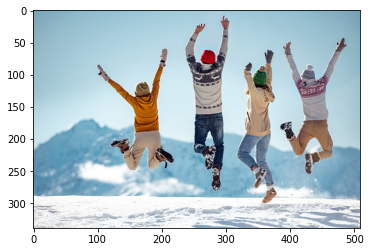

In [117]:
x2=plt.imread(pic2)
plt.imshow(x2)
plt.show()

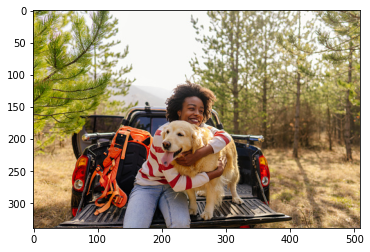

In [118]:
pic3 = 'Flicker8k_Dataset/1319657625-170667a.jpg'
inp3 = image.load_img(pic3,target_size=(299,299))
inp3 = image.img_to_array(inp3)
x3 = np.expand_dims(inp3, axis=0)
x3 = preprocess_input(x3)
image3 = encode_new_image(x3).reshape((1,2048))
plt.imshow(plt.imread(pic3))
plt.show()

In [119]:
print("Greedy Search:",greedySearch(image3))
print("Beam Search, K = 3:",beam_search_predictions(image3, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image3, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image3, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image3, beam_index = 10))

Greedy Search: a white dog is walking through the snow
Beam Search, K = 3: a white dog with a blue blanket in the water
Beam Search, K = 5: a small white dog with a red ribbon in its mouth sits on a sidewalk
Beam Search, K = 7: a small white dog and a white dog are playing in the snow
Beam Search, K = 10: a white dog and a white dog are playing in the snow
